In [4]:
import sys, os, re, gzip, json, pickle, shutil, random, joblib

import numpy as np
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD

from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
data_path = '../data'

# the path to the user and troll features

user_feature_path = data_path + "/user_features.pkl"
troll_feature_path = data_path + "/troll_features.pkl"

In [6]:
# pickle data

def getDataFromPickle(path):
    f = open(path, 'rb')
    return pickle.load(f)

In [7]:
# get data from pickle

user_feature_list = getDataFromPickle(user_feature_path)
troll_feature_list = getDataFromPickle(troll_feature_path)

In [8]:
# combine the lists together

combine = user_feature_list[:500000] + troll_feature_list[:500000]

In [9]:
# shuffle the lists

random.shuffle(combine)

# create the y set by doing 0 for normal user and 1 if anything else
y = [0 if f["type"] == 'NormalUser' else 1 for f in combine]

In [10]:
# open the pickle

with gzip.open('../data/1000000_features_x.pkl.gz', 'wb') as oz:
    pickle.dump(combine, oz)
    
with gzip.open('../data/1000000_features_y.pkl', 'wb') as o:
    pickle.dump(y, o)

In [11]:
# get a list of specifically lemmas and tokens

lemmas = [f["lemmas"] for f in combine]
texts = [f["tokens"] for f in combine]

In [12]:
# clear the list because memory

combine=user_feature_list=troll_feature_list=None

In [13]:
# run a vectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=50000, stop_words="english")

tfidf = tfidf_vectorizer.fit_transform(texts)

joblib.dump(tfidf, '1000000_tfidf_texts.joblib') 

['1000000_tfidf_texts.joblib']

In [14]:
# divide into test and traid in a 9:1 split

x_tfidf_train = tfidf[:-10000,:]
y_tfidf_train = np.array(y[:-10000])
x_tfidf_test = tfidf[-10000:,:]
y_tfidf_test = np.array(y[-10000:])

In [15]:
# run svm on the texts

svm = LinearSVC(dual = False)
svm.fit(x_tfidf_train, y_tfidf_train)
print(svm.score(x_tfidf_test, y_tfidf_test))  

0.9042


In [16]:
# get predicted 
predicted = cross_val_predict(svm, x_tfidf_test, y_tfidf_test, cv=2)

In [17]:
# print the classification report with normal user or troll users
print(classification_report(y_tfidf_test, predicted, target_names=['NormalUser', 'TrollUser']))

              precision    recall  f1-score   support

  NormalUser       0.79      0.84      0.81      4956
   TrollUser       0.83      0.78      0.80      5044

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



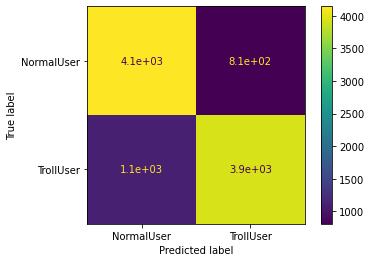

In [18]:
# show confusion matrix based on predicted

cm = confusion_matrix(y_tfidf_test, predicted)
cmd = ConfusionMatrixDisplay(cm, display_labels=['NormalUser', 'TrollUser'])
cmd.plot()

In [19]:
# show top feature names

feature_names = tfidf_vectorizer.get_feature_names() 
coefs_with_fns = sorted(zip(svm.coef_[0], feature_names)) 
df = pd.DataFrame(coefs_with_fns)
df.columns='coefficient','word'
df.sort_values(by='coefficient')

,coefficient,word
0,-5.364279,com
1,-3.881465,10news
2,-3.663028,nctimes
3,-3.611791,h1n1
4,-3.540477,youmightbealiberal
...,...,...
49995,5.928000,sports
49996,6.072881,realdonaldtrump
49997,6.264873,pjnet
49998,6.583970,amp


In [20]:
# print the top 20
print(df.head(20))

    coefficient                word
0     -5.364279                 com
1     -3.881465              10news
2     -3.663028             nctimes
3     -3.611791                h1n1
4     -3.540477  youmightbealiberal
5     -3.400964                2009
6     -3.385784                  39
7     -3.361122                 hcr
8     -3.280440            clenched
9     -3.229279                cofc
10    -3.226750                 www
11    -3.225826               acorn
12    -3.224701          proverbs29
13    -3.217219              stupak
14    -3.174971          proverbs28
15    -3.162138                 dbj
16    -3.081225                2010
17    -3.040358        dawgfootball
18    -3.017529                awsr
19    -2.956625                amdt


In [21]:
# print the lowest 20
print(df.tail(20))

       coefficient                               word
49980     4.511075               sextingwentwrongwhen
49981     4.530341  alternativeacronyminterpretations
49982     4.599883                              emoji
49983     4.617403                       obamanextjob
49984     4.834614                          worldnews
49985     4.861291                           staywoke
49986     4.994293        survivalguidetothanksgiving
49987     5.098878                            stlouis
49988     5.458258                       blacktwitter
49989     5.509020                              trump
49990     5.542363            todolistbeforechristmas
49991     5.638179                           topvideo
49992     5.639931                               2017
49993     5.643614                               maga
49994     5.708059                   blacklivesmatter
49995     5.928000                             sports
49996     6.072881                    realdonaldtrump
49997     6.264873          

In [22]:
# run logistic regression on the set
lr = LogisticRegression(max_iter=2000)
lr.fit(x_tfidf_train, y_tfidf_train)
print(lr.score(x_tfidf_test, y_tfidf_test))  

0.8999


In [23]:
# show the dataframe of it
feature_names = tfidf_vectorizer.get_feature_names() 
coefs_with_fns = sorted(zip(lr.coef_[0], feature_names)) 
df = pd.DataFrame(coefs_with_fns)
df.columns='coefficient','word'
df.sort_values(by='coefficient')

,coefficient,word
0,-13.974255,com
1,-9.808022,2009
2,-9.358992,39
3,-8.411807,2010
4,-8.019806,www
...,...,...
49995,13.272224,topvideo
49996,16.610280,trump
49997,17.229384,amp
49998,17.571181,sports


In [24]:
# vectorize the lemmas
tfidf_vectorizer_lemma = TfidfVectorizer(max_features=50000, stop_words="english")

tfidf_lemma = tfidf_vectorizer_lemma.fit_transform(lemmas)

joblib.dump(tfidf, '1000000_tfidf_lemmas.joblib') 

['1000000_tfidf_lemmas.joblib']

In [25]:
# split 9:1 for lemma test train

x_tfidf_train_lemma = tfidf_lemma[:-10000,:]
y_tfidf_train_lemma = np.array(y[:-10000])
x_tfidf_test_lemma = tfidf_lemma[-10000:,:]
y_tfidf_test_lemma = np.array(y[-10000:])

In [26]:
# use svc on the lemmas
svm_lemma = LinearSVC(dual = False)
svm_lemma.fit(x_tfidf_train_lemma, y_tfidf_train_lemma)
print(svm_lemma.score(x_tfidf_test_lemma, y_tfidf_test_lemma))  

0.8949


In [27]:
# cross validate the lemmas
predicted_lemma = cross_val_predict(svm_lemma, x_tfidf_test_lemma, y_tfidf_test_lemma, cv=2)

In [28]:
# print the results
print(classification_report(y_tfidf_test_lemma, predicted_lemma, target_names=['NormalUser', 'TrollUser']))

              precision    recall  f1-score   support

  NormalUser       0.77      0.84      0.80      4956
   TrollUser       0.83      0.75      0.79      5044

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



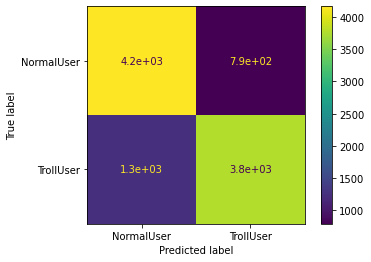

In [29]:
# confusion matrix on the lemmas
cm_lemma = confusion_matrix(y_tfidf_test_lemma, predicted_lemma)
cmd_lemma = ConfusionMatrixDisplay(cm_lemma, display_labels=['NormalUser', 'TrollUser'])
cmd_lemma.plot()

In [30]:
# show df for feature names
feature_names_lemma = tfidf_vectorizer_lemma.get_feature_names() 
coefs_with_fns_lemma = sorted(zip(svm_lemma.coef_[0], feature_names_lemma)) 
df_lemma = pd.DataFrame(coefs_with_fns_lemma)
df_lemma.columns='coefficient','word'
df_lemma.sort_values(by='coefficient')

,coefficient,word
0,-4.851605,com
1,-3.763861,10news
2,-3.665420,nctime
3,-3.591998,h1n1
4,-3.567152,www
...,...,...
49995,5.697814,2017
49996,5.733560,maga
49997,5.959786,pjnet
49998,6.375840,amp


In [31]:
# print the top 20
print(df_lemma.head(20))

    coefficient                word
0     -4.851605                 com
1     -3.763861              10news
2     -3.665420              nctime
3     -3.591998                h1n1
4     -3.567152                 www
5     -3.553856  youmightbealiberal
6     -3.454131                 hcr
7     -3.287720                cofc
8     -3.263929              stupak
9     -3.240421                awsr
10    -3.203742          proverbs28
11    -3.193957          proverbs29
12    -3.180813                2009
13    -3.135344               acorn
14    -3.117598                  39
15    -2.989577        dawgfootball
16    -2.985274                  kt
17    -2.954397                2010
18    -2.953465                tbot
19    -2.918213        youraudiofix


In [32]:
# print the lowest 20

print(df_lemma.tail(20))

       coefficient                       word
49980     4.218748                        amb
49981     4.219349                    hillary
49982     4.528510  survivalguidetothanksgive
49983     4.558540         christmasaftermath
49984     4.614601                   staywoke
49985     4.650542                    stlouis
49986     5.049089                  worldnews
49987     5.124169                 nowplaying
49988     5.145565           blacklivesmatter
49989     5.157339               blacktwitter
49990     5.240431                      trump
49991     5.407110                      sport
49992     5.496959     todolistbeforechristma
49993     5.498467            realdonaldtrump
49994     5.499121                   topvideo
49995     5.697814                       2017
49996     5.733560                       maga
49997     5.959786                      pjnet
49998     6.375840                        amp
49999     6.673104                    topnews


In [33]:
# Logistic regression for lemmas

lr_lemma = LogisticRegression(max_iter=2000)
lr_lemma.fit(x_tfidf_train_lemma, y_tfidf_train_lemma)
print(lr.score(x_tfidf_test_lemma, y_tfidf_test_lemma)) 

0.5104


In [34]:
# feature df for lemmas

feature_names_lemma = tfidf_vectorizer_lemma.get_feature_names() 
coefs_with_fns_lemma = sorted(zip(lr_lemma.coef_[0], feature_names_lemma)) 
df_lemma = pd.DataFrame(coefs_with_fns)
df_lemma.columns='coefficient','word'
df_lemma.sort_values(by='coefficient')

,coefficient,word
0,-13.974255,com
1,-9.808022,2009
2,-9.358992,39
3,-8.411807,2010
4,-8.019806,www
...,...,...
49995,13.272224,topvideo
49996,16.610280,trump
49997,17.229384,amp
49998,17.571181,sports
